In [1]:
import sys
import ROOT
import numpy as np
import pandas as pd
import root_pandas
import seaborn as sb
import matplotlib.pyplot as plt
import uproot
import time

from itertools import product

#from root_numpy import root2array

from keras.models import Sequential
from keras.layers import Dense

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.preprocessing import QuantileTransformer
import pickle

Welcome to JupyROOT 6.16/00


/Users/jonamotta/anaconda3/envs/python_root/lib/python2.7/site-packages/root_numpy/__init__.py:46: RuntimeWarning: numpy 1.16.3 is currently installed but you installed root_numpy against numpy 1.9.3. Please consider reinstalling root_numpy for this numpy version.
  RuntimeWarning)
Using TensorFlow backend.


In [2]:
#######################################################
### ADD TARGET COLUMNS AND SAVE CSV FILES OF EVENTS ###
#######################################################


features = [
    'm2_miss', #missing mass square (p_B - p_mu1 - p_mu2 - p_mu)^2
    'muE_Brf', #mu energy in the Bc rest frame
    'q2', #squared 4momentum transfer to lepton sys (p_B - p_mu1 - p_mu2)^2
    'pT_miss', #missing transverse momentum (p_B - p_mu1 - p_mu2 - p_mu).Pt
    'muE_muSysRf', # unpaired muon energy in the rest frame of the jpsi muons sys
    'pT_var', # difference between the jpsi muons pT
    'jpsi_mass_diffReco', # mu_sys.Mag() - jpsi_mass
    'deltaR_mu1mu2', # deltaR between the two muon reconstructing the jpsi
    'mu_pt',
    'mu_eta',
    'mu_phi',
    'mu1_pt',
    'mu1_eta',
    'mu1_phi',
    'mu2_pt',
    'mu2_eta',
    'mu2_phi'
]

mu_events = pd.read_csv('mu_events_NOCUT.csv')
tau_events = pd.read_csv('tau_events_NOCUT.csv')
bkg_events = pd.read_csv('bkg_events_NOCUT.csv')

mu_CUT = pd.read_csv('mu_events_CUT.csv')
tau_CUT = pd.read_csv('tau_events_CUT.csv')
bkg_CUT = pd.read_csv('bkg_events_CUT.csv')

# drop the events corresponding to those that we will evaluate our NN on
# we do it because they are few and we want to avoid training in the same dataset on which we will evaluate
#mu_events = mu_events.drop(mu_CUT['tree_index'], axis=0)
#tau_events = tau_events.drop(tau_CUT['tree_index'], axis=0)

In [3]:
#########################################
### PREPARE DFs FOR TRAINING AND TEST ###
#########################################

# concatenate the two samples
dataset = pd.concat([mu_events, tau_events, bkg_events],sort=False)

# shuffle and split train/test
train, test = train_test_split(dataset, test_size=0.85, random_state=1986, shuffle=True)

# X and Y on the training sample
X = pd.DataFrame(train, columns=features)
Y = pd.DataFrame(train, columns=['target_sgnNN'])

In [4]:
##################
### PREPROCESS ###
##################


qt = QuantileTransformer(output_distribution='normal', random_state=1986)
qt.fit(X[features])
transformedX = pd.DataFrame(qt.transform(X[features]),columns=features)
pickle.dump( qt, open( 'quantile_tranformation_sgnNN.pck', 'w' ) )

In [5]:
########################
### DEFINE THE MODEL ###
########################

# model defined and fitted with parameters set with BAYESIAN OPTIMIZATION

# define the model
model = Sequential()
for i in range(4):
    model.add(Dense(128, input_dim=len(features),activation='relu'))
model.add(Dense(1,activation='sigmoid'))


# compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [6]:
#######################
### TRAIN THE MODEL ###
#######################


# fit the model
model.fit(transformedX, Y, epochs=10, batch_size=30, validation_split=0.5)
#model.fit(X, Y, epochs=20, batch_size=2290, validation_split=0.5)

Instructions for updating:
Use tf.cast instead.
Train on 86097 samples, validate on 86098 samples
Epoch 1/10
86097/86097 [==============================] - 6s 71us/step - loss: 0.2722 - acc: 0.8805 - val_loss: 0.2600 - val_acc: 0.8867
Epoch 2/10
86097/86097 [==============================] - 6s 65us/step - loss: 0.2531 - acc: 0.8912 - val_loss: 0.2530 - val_acc: 0.8907
Epoch 3/10
86097/86097 [==============================] - 6s 65us/step - loss: 0.2458 - acc: 0.8948 - val_loss: 0.2434 - val_acc: 0.8962
Epoch 4/10
86097/86097 [==============================] - 6s 65us/step - loss: 0.2409 - acc: 0.8970 - val_loss: 0.2435 - val_acc: 0.8954
Epoch 5/10
86097/86097 [==============================] - 6s 65us/step - loss: 0.2370 - acc: 0.8990 - val_loss: 0.2452 - val_acc: 0.8937
Epoch 6/10
86097/86097 [==============================] - 6s 65us/step - loss: 0.2339 - acc: 0.9005 - val_loss: 0.2384 - val_acc: 0.8974
Epoch 7/10
86097/86097 [==============================] - 6s 65us/step - loss: 0

2019-08-09 12:52:33.673383: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA


In [7]:
######################################
### TEST THE TRAINING OF THE MODEL ###
######################################


# evaluate the model
scores = model.evaluate(transformedX, Y)
#scores = model.evaluate(X, Y)
print("\n%s: %.2f%%" % (model.metrics_names[0], scores[0]*100))
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

# calculate predictions on the test sample
print 'predicting on', test.shape[0], 'events'
x = pd.DataFrame(test, columns=features)
qt = pickle.load(open( 'quantile_tranformation_sgnNN.pck', 'r' ))
transformedx = qt.transform(x[features])
y = model.predict(transformedx)
#y = model.predict(x)

# add the score to the test sample dataframe
test.insert(len(test.columns), 'nn_score', y)

172195/172195 [==============================] - 3s 15us/step 

loss: 22.62%
acc: 90.51%
predicting on 975775 events


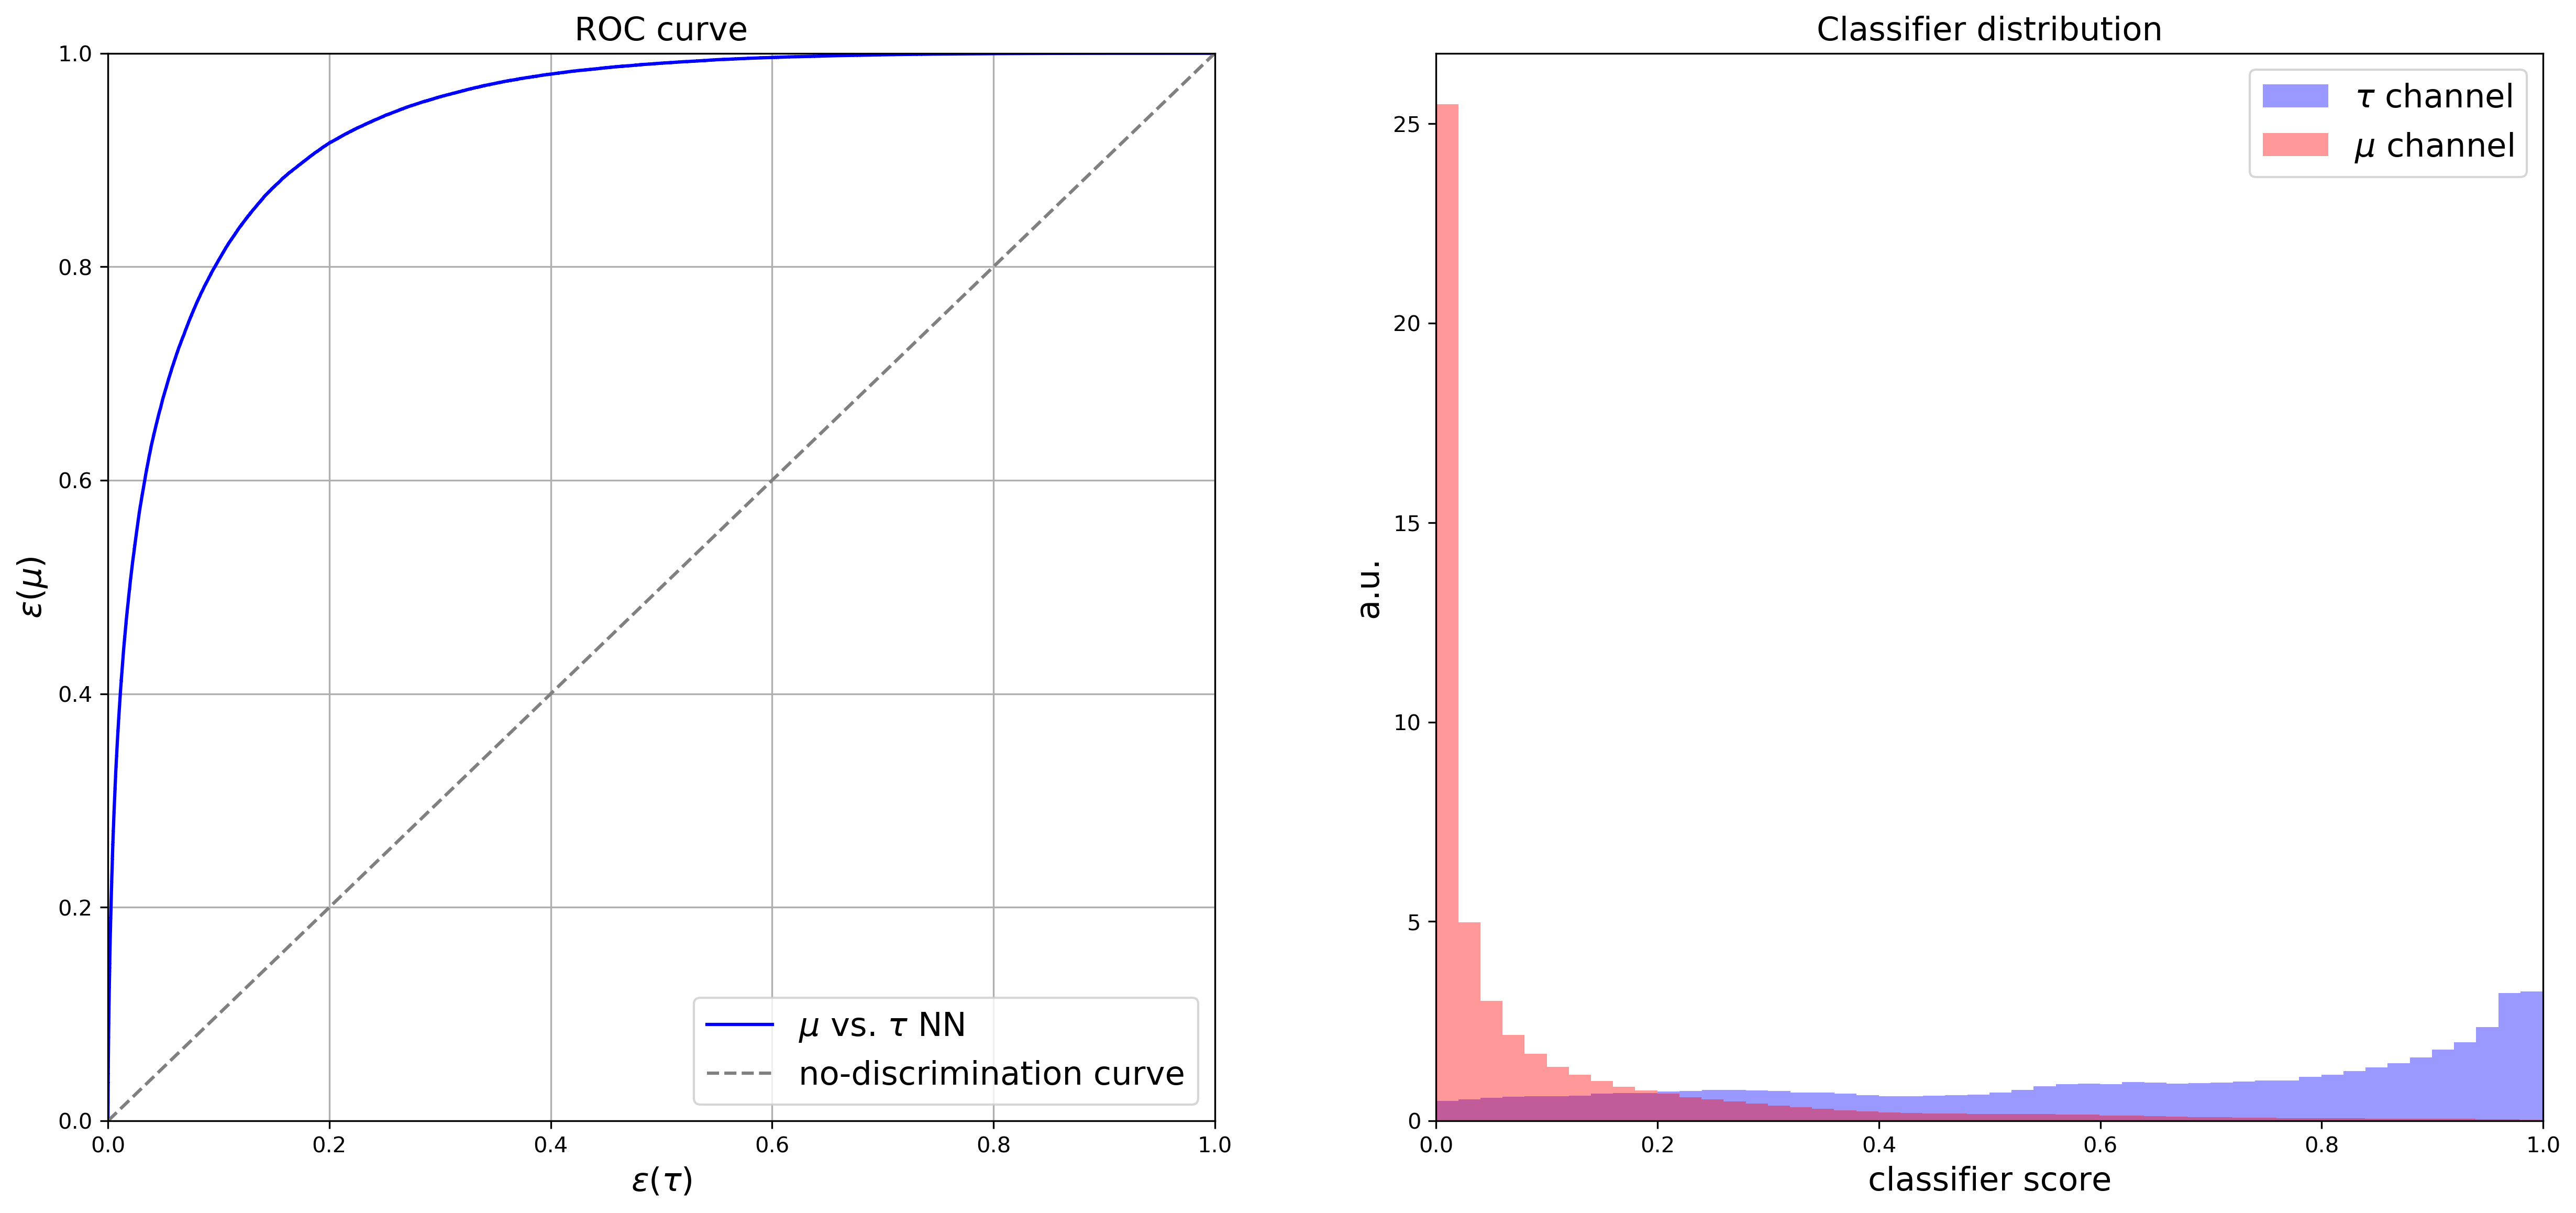

In [8]:
##########################
### ROC & SCORE CURVES ###
##########################


# let sklearn do the heavy lifting and compute the ROC curves for you
fpr, tpr, wps = roc_curve(test.target_sgnNN, test.nn_score)

fig = plt.figure(dpi=300)
fig.set_size_inches(20,9)
ax = fig.add_subplot(121)
# plot
plt.plot(fpr, tpr, label=r'$\mu$ vs. $\tau$ NN', color='b')
# plot also the diagonal, that corresponds to random picks, no discrimination power
xy = [i*j for i,j in product([10.**i for i in range(-8, 0)], [1,2,4,8])]+[1]
plt.plot(xy, xy, color='grey', linestyle='--', label='no-discrimination curve')
# cosmetics
ax.set_title('ROC curve',fontsize=15)
ax.set_xlabel(r'$\epsilon(\tau)$', fontsize=15)
ax.set_ylabel(r'$\epsilon(\mu)$', fontsize=15)
# axis range
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
# grid
plt.grid(True)
# legend
plt.legend(loc='best', fontsize=15)
# save figure and then clean it
plt.savefig('selectionNN_roc.pdf')
#plt.show()
#plt.clf()
ax = fig.add_subplot(122)
# plot the discriminator shape for the muon and tau channel
test_tau = test[test.target_sgnNN==1]
test_mu  = test[test.target_sgnNN==0]
sb.distplot(test_tau['nn_score'], kde=False, norm_hist=True, label=r'$\tau$ channel', color='b')
sb.distplot(test_mu ['nn_score'], kde=False, norm_hist=True, label=r'$\mu$ channel' , color='r')
ax.set_title('Classifier distribution', fontsize=15)
ax.set_xlabel('classifier score',fontsize=15)
ax.set_ylabel('a.u.', fontsize=15)
plt.xlim([0.0, 1.0])
#plt.ylim([0.0, 0.25])
plt.legend(loc='upper right', fontsize=15)
plt.savefig('selectionNN_score.pdf')
#plt.show()
#plt.clf()

In [9]:
# compute the auc
auroc = auc(fpr, tpr)
print "AUC =", auroc 

# compute Gini index
print "Gini index =", (auroc-0.5)*2

sgn = test[test.nn_score>0.4]
sgn = sgn[sgn.target_sgnNN>0]
norm = test[test.target_sgnNN>0]
epsilon = float(sgn['nn_score'].count())/float(norm['nn_score'].count())
print 'Efficiency of signal discrimination from background =', epsilon

sgn = test[test.nn_score>0.4]
sgn = sgn[sgn.target_sgnNN>0]
norm = test[test.nn_score>0.4]
pi = float(sgn['nn_score'].count())/float(norm['nn_score'].count())
print 'Purity of signal discrimination from background =', pi

print r'$\epsilon \cdot \pi$ = ', epsilon * pi

AUC = 0.9383895855504585
Gini index = 0.876779171100917
Efficiency of signal discrimination from background = 0.730614265715
Purity of signal discrimination from background = 0.707374858812
$\epsilon \cdot \pi$ =  0.516818163056


predicting on 3169 events
AUC = 0.8442859461872491
Gini index = 0.6885718923744981
Efficiency of signal discrimination from background = 0.00609756097561


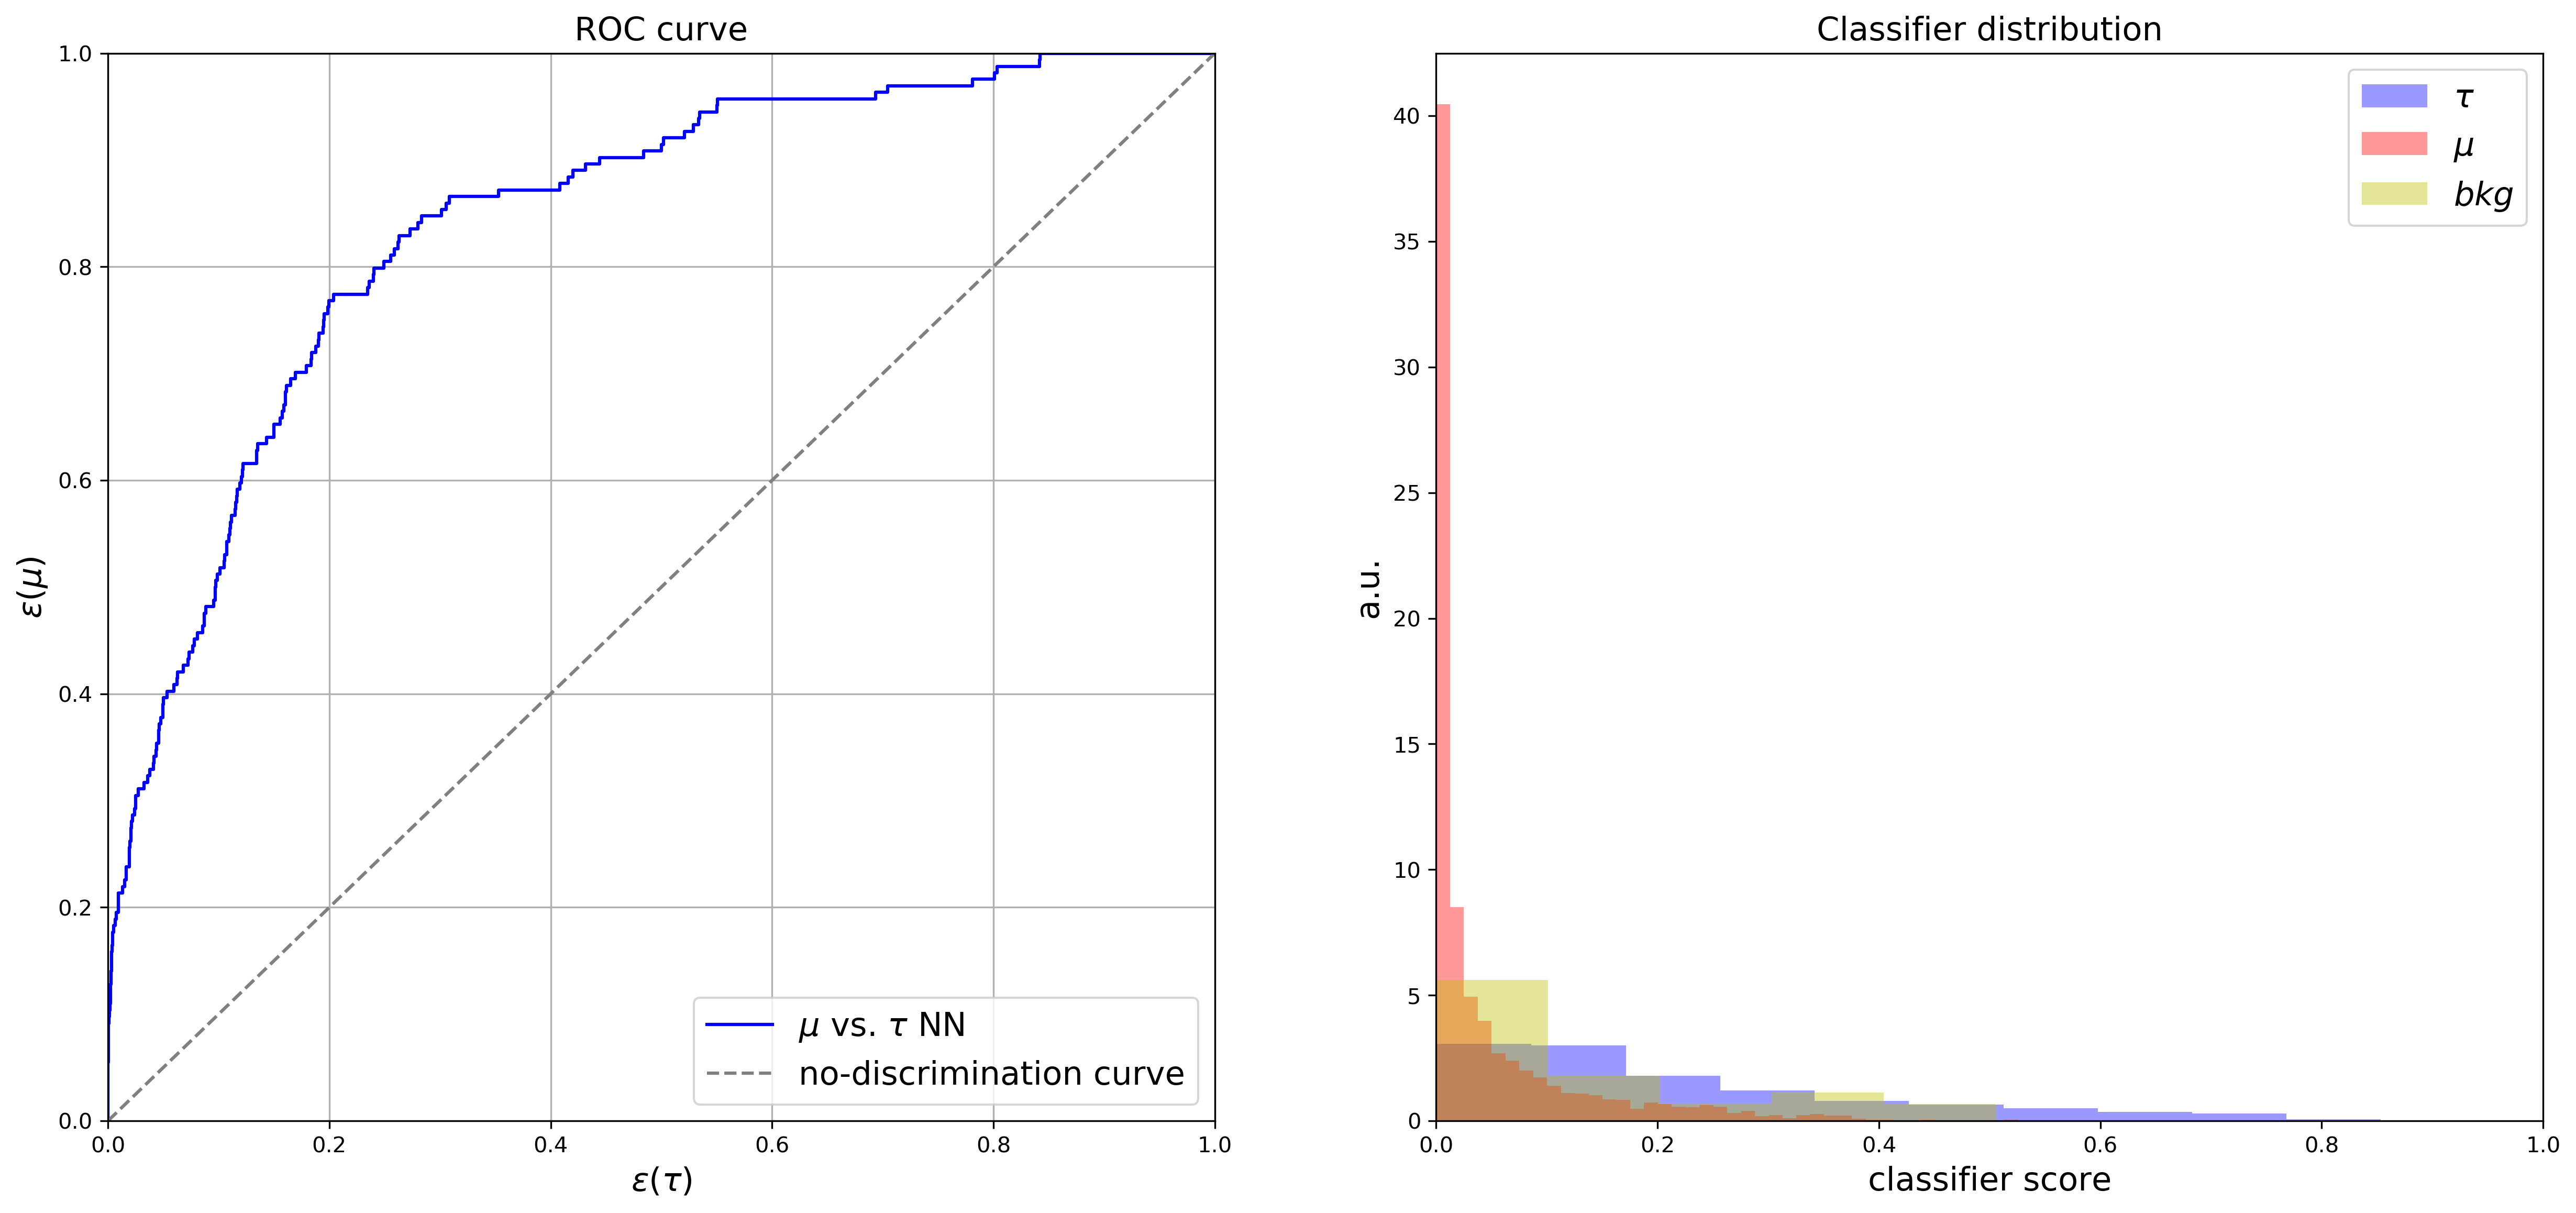

In [10]:
###########################################################
### EVALUATE THE MODEL ON THE DATA THAT PASSED THE CUTS ###
###########################################################

bkg_CUT = pd.read_csv('bkg_events_CUT.csv')

data = pd.concat([mu_CUT, tau_CUT, bkg_CUT],sort=True)

# calculate predictions on the data sample
print 'predicting on', data.shape[0], 'events'
x = pd.DataFrame(data, columns=features)
qt = pickle.load(open( 'quantile_tranformation_sgnNN.pck', 'r' ))
transformedx = qt.transform(x[features])
y = model.predict(transformedx)

# add the score to the data sample dataframe
data.insert(len(data.columns), 'sgnNN_score', y)

# let sklearn do the heavy lifting and compute the ROC curves for you
fpr, tpr, wps = roc_curve(data.target_sgnNN, data.sgnNN_score)

fig = plt.figure(dpi=300)
fig.set_size_inches(20,9)
ax = fig.add_subplot(121)
# plot
plt.plot(fpr, tpr, label=r'$\mu$ vs. $\tau$ NN', color='b')
# plot also the diagonal, that corresponds to random picks, no discrimination power
xy = [i*j for i,j in product([10.**i for i in range(-8, 0)], [1,2,4,8])]+[1]
plt.plot(xy, xy, color='grey', linestyle='--', label='no-discrimination curve')
# cosmetics
ax.set_title('ROC curve', fontsize=15)
ax.set_xlabel(r'$\epsilon(\tau)$', fontsize=15)
ax.set_ylabel(r'$\epsilon(\mu)$', fontsize=15)
# axis range
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
# grid
plt.grid(True)
# legend
plt.legend(loc='best', fontsize=15)
# save figure and then clean it
plt.savefig('sgn_bkg_roc.pdf')
#plt.show()
#plt.clf()
ax = fig.add_subplot(122)
# plot the discriminator shape for the muon and tau channel
data_tau = data[data.target_sgnNN==1]
data_mu  = data[data.target_sgnNN==0]
data_mu = data_mu[data_mu.target_bkgNN==1]
data_bkg  = data[data.target_sgnNN==0]
data_bkg = data_bkg[data_bkg.target_bkgNN==0]
sb.distplot(data_tau['sgnNN_score'], kde=False, norm_hist=True, label=r'$\tau$', color='b')
sb.distplot(data_mu['sgnNN_score'], kde=False, norm_hist=True, label=r'$\mu$' , color='r')
sb.distplot(data_bkg['sgnNN_score'], kde=False, norm_hist=True, label=r'$bkg$' , color='y')
ax.set_title('Classifier distribution', fontsize=15)
ax.set_xlabel('classifier score', fontsize=15)
ax.set_ylabel('a.u.', fontsize=15)
plt.xlim([0.0, 1.0])
plt.legend(loc='best', fontsize=15)
plt.savefig('sgn_bkg_score.pdf')
#plt.show()
#plt.clf()

# compute the auc
auroc = auc(fpr, tpr)
print "AUC =", auroc 

# compute Gini index
print "Gini index =", (auroc-0.5)*2

sgn = data[data.sgnNN_score>0.8]
sgn = sgn[sgn.target_sgnNN>0]
norm = data[data.target_sgnNN>0]
print 'Efficiency of signal discrimination from background =', float(sgn['sgnNN_score'].count())/float(norm['sgnNN_score'].count())

#sgn = data[data.sgnNN_score>0.8]
#sgn = sgn[sgn.target_sgnNN>0]
#norm = data[data.sgnNN_score>0.8]
#print 'Purity of signal discrimination from background =', float(sgn['sgnNN_score'].count())/float(norm['sgnNN_score'].count())

In [13]:
mu_final_CUT = data[data['target_sgnNN']==0]
mu_final_CUT = mu_final_CUT[mu_final_CUT['target_bkgNN']==1]
bkg_final_CUT = data[data['target_sgnNN']==0]
bkg_final_CUT = bkg_final_CUT[bkg_final_CUT['target_bkgNN']==0]
tau_final_CUT = data[data['target_sgnNN']==1]

In [14]:
mu_final_CUT.to_csv('mu_channel_CUT.csv')
tau_final_CUT.to_csv('tau_channel_CUT.csv')
bkg_final_CUT.to_csv('bkg_channel_CUT.csv')
test_mu.to_csv('mu_channel_NOCUT.csv')
test_tau.to_csv('tau_channel_NOCUT.csv')